# System Message Test
Goal: Get best system message for all models, tasks, and datasets

Overall Summary:
- System message 1 shows the best performance accross all models and tasks
- a positive and negative example helps the model to respond in the wanted way
- for some models, many probability values do not match with the predicted label. The provided guidance in System Message 3-5 further increased the number of mismatches.
- very bad performance across the board
- clustering of probability values observed for all models except Deepseek-R1. 

---

In [81]:
import pandas as pd
import numpy as np
import os
import sys
import re
import json
import matplotlib.pyplot as plt
import sys

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.metrics import calculate_all_metrics, calculate_auprc, calculate_auroc

In [82]:
outputfolder_path_list = [
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test"
]

In [83]:
def categorize_files(outputfolder_path_list):
    """
    Categorize files in the output folders into metrics report files, metadata files, and log files.

    Args:
        outputfolder_path_list (list): List of output folder paths.

    Returns:
        dict: A dictionary containing categorized files.
    """
    file_list = []
    for outputfolder_path in outputfolder_path_list:
        # List all files in the folder and its subfolders
        for root, dirs, files in os.walk(outputfolder_path):
            for file in files:
                file_list.append(os.path.join(root, file))

    categorized_files = {
        "metrics_report_files": [f for f in file_list if "metrics_report" in f],
        "metadata_files": [f for f in file_list if "metadata" in f],
        "log_files": [f for f in file_list if "log" in f],
    }

    print("Metrics Report Files:")
    for file in categorized_files["metrics_report_files"]:
        print(file)
    print("\nMetadata Files:")
    for file in categorized_files["metadata_files"]:
        print(file)
    print("\nLog Files:")
    for file in categorized_files["log_files"]:
        print(file)

    return categorized_files
    

In [84]:
def load_metadata(metadata_path_list):
    """
    Load metadata from a CSV file into a DataFrame.
    
    Args:
        metadata_path (str): Path to the metadata CSV file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metadata.
    """
    df_mdata = pd.DataFrame()
    for m_path in metadata_path_list:
        try:
            df = pd.read_csv(m_path)
            # Extract model name, task, dataset, and timestamp from the metadata path
            # match = re.search(
            #     r"\\([^\\]+)_([^_]+)_([^_]+)_(\d{8}_\d{6})_metadata\.csv$", m_path
            # )
            match1 = re.search(
                r"\\([0-9]{8}_[0-9]{6})_[^\\]+\\([^_]+)_([^_]+)_([^_]+)_output_metadata\.csv$", m_path
            )
            match2 = re.search(
                r"\\([0-9]{8}_[0-9]{6})_[^\\]+\\([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_metadata\.csv$",
                m_path,
            )

            if match1:
                timestamp, model_name, task, dataset = match1.groups()
                print(f"Model Name: {model_name}, Task: {task}, Dataset: {dataset}, Timestamp: {timestamp}")
                # Add extracted metadata to the DataFrame
                df['model_name'] = model_name
                df['task'] = task
                df['dataset'] = dataset
                df['timestamp'] = timestamp

            elif match2:
                timestamp, model_name, task, dataset, _ , _ = match2.groups()
                print(
                    f"Model Name: {model_name}, Task: {task}, Dataset: {dataset}, Timestamp: {timestamp}"
                )
                # Add extracted metadata to the DataFrame
                df["model_name"] = model_name
                df["task"] = task
                df["dataset"] = dataset
                df["timestamp"] = timestamp

            else:
                print("Failed to extract metadata details from the path. Using default values.")
                df['model_name'] = "Unknown"
                df['task'] = "Unknown"
                df['dataset'] = "Unknown"
                df['timestamp'] = "Unknown"

            # Append the DataFrame to the main DataFrame
            df_mdata = pd.concat([df_mdata, df], ignore_index=True)

        except Exception as e:
            print(f"Error loading metadata: {e}")
            continue
    return df_mdata

In [85]:
def load_metrics_report_as_df(metrics_report_path):
    """
    Load metrics report from a JSON file and return it as a DataFrame.
    
    Args:
        metrics_report_path (str): Path to the metrics report JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metrics report.
    """
    try:
        with open(metrics_report_path, 'r') as f:
            metrics_report = json.load(f)
        df = pd.DataFrame(metrics_report)
        return df
    except Exception as e:
        print(f"Error loading metrics report: {e}")
        return None

In [86]:
def get_predictions_by_model_task_dataset(df, model, task, dataset):
    """
    Filter predictions DataFrame by model, task, and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df['model_name'] == model) & (df['task'] == task) & (df['dataset'] == dataset)]

In [87]:
def get_predictions_by_task_dataset(df, task, dataset):
    """
    Filter predictions DataFrame by task and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df["task"] == task) & (df["dataset"] == dataset)]

In [88]:
def get_predictions_by_model(df, model):
    """
    Filter predictions DataFrame by model.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["model_name"] == model]

In [89]:
def plot_metrics(df, titel_prefix):
    # Calculate all metrics for each unique System Message Index
    metrics_by_sys_msg_idx = {}

    for idx in df["System Message Index"].unique():
        subset = df[df["System Message Index"] == idx]
        y_true = subset['Target Label'].values
        y_pred = subset['Predicted Probability'].values
        metrics = calculate_all_metrics(y_true, y_pred)
        metrics_by_sys_msg_idx[idx] = metrics

    # Prepare data for plotting
    indices = list(metrics_by_sys_msg_idx.keys())
    metrics_names = list(next(iter(metrics_by_sys_msg_idx.values())).keys())

    # Create a grouped bar plot: x-axis = metric, bars = System Message Index
    bar_width = 0.2
    x = np.arange(len(metrics_names))

    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(indices):
        values = [metrics_by_sys_msg_idx[idx][metric] for metric in metrics_names]
        plt.bar(x + i * bar_width, values, width=bar_width, label=f'System Msg {idx}')

    plt.xticks(x + bar_width * (len(indices) - 1) / 2, metrics_names, rotation=45, ha='right')
    plt.ylabel('Metric Value')
    plt.title(f"{titel_prefix} - Metrics by System Message (Grouped by Metric)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [90]:
cat_files = categorize_files(outputfolder_path_list)

Metrics Report Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250608_180109_gemma_mortality\Gemma3_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250608_181930_llama38b_sys_msgs_test\Llama3_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250608_182848_mistral7b_sysmsgtest\Mistral_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250613_112431_deepseekr1_llama8b_sys_msgs_test\DeepseekR1Llama8b_metrics_report.json

Metadata Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250608_180109_gemma_mortality\Gemma3_mortality_eicu_20250608_180109_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\20250608_181930_llama38b_sys_msgs_test\Llama3_aki_eicu_20250608_181930_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\sys_msgs_test\202506

In [91]:
df_metadata = load_metadata(cat_files["metadata_files"])

Model Name: Gemma3, Task: mortality, Dataset: eicu, Timestamp: 20250608_180109
Model Name: Llama3, Task: aki, Dataset: eicu, Timestamp: 20250608_181930
Model Name: Llama3, Task: mortality, Dataset: eicu, Timestamp: 20250608_181930
Model Name: Llama3, Task: sepsis, Dataset: eicu, Timestamp: 20250608_181930
Model Name: Mistral, Task: aki, Dataset: eicu, Timestamp: 20250608_182848
Model Name: Mistral, Task: mortality, Dataset: eicu, Timestamp: 20250608_182848
Model Name: Mistral, Task: sepsis, Dataset: eicu, Timestamp: 20250608_182848
Model Name: DeepseekR1Llama8b, Task: aki, Dataset: eicu, Timestamp: 20250613_112431
Model Name: DeepseekR1Llama8b, Task: mortality, Dataset: eicu, Timestamp: 20250613_112431
Model Name: Gemma3, Task: aki, Dataset: eicu, Timestamp: 20250616_135330


---
### Experiment Summary
Metrics averaged over all models, tasks and datasets for the 5 different system messages

In [99]:
df_metrics_by_model_task = (
    df_metadata.groupby(["model_name", "task", "System Message Index"])
    .apply(lambda x: calculate_all_metrics(x["Target Label"].values, x["Predicted Probability"].values))
    .reset_index()
)

metrics_expanded = df_metrics_by_model_task[0].apply(pd.Series)
df_metrics_by_model_task = pd.concat([df_metrics_by_model_task.drop(columns=0), metrics_expanded], axis=1)


C:\Users\janbe\AppData\Local\Temp\ipykernel_23676\2327640420.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_all_metrics(x["Target Label"].values, x["Predicted Probability"].values))


In [100]:
df_metrics_by_model_task

,model_name,task,System Message Index,auroc,auprc,normalized_auprc,specificity,f1_score,accuracy,balanced_accuracy,precision,recall,mcc,kappa,minpse
0,DeepseekR1Llama8b,aki,0,0.556,0.353,1.140,0.772,0.348,0.631,0.545,0.385,0.318,0.095,0.094,0.383
1,DeepseekR1Llama8b,aki,1,0.586,0.392,1.264,0.820,0.342,0.655,0.554,0.419,0.289,0.123,0.119,0.382
2,DeepseekR1Llama8b,aki,2,0.567,0.403,1.301,0.803,0.359,0.651,0.559,0.417,0.315,0.128,0.126,0.401
3,DeepseekR1Llama8b,aki,3,0.562,0.392,1.264,0.803,0.359,0.651,0.559,0.417,0.315,0.128,0.126,0.368
4,DeepseekR1Llama8b,aki,4,0.588,0.436,1.406,0.834,0.367,0.671,0.571,0.454,0.308,0.161,0.156,0.413
5,DeepseekR1Llama8b,mortality,0,0.790,0.169,2.409,0.462,0.190,0.490,0.660,0.107,0.857,0.164,0.075,0.194
6,DeepseekR1Llama8b,mortality,1,0.661,0.234,3.344,0.613,0.208,0.620,0.664,0.122,0.714,0.170,0.101,0.135
7,DeepseekR1Llama8b,mortality,2,0.674,0.137,1.951,0.559,0.189,0.570,0.637,0.109,0.714,0.140,0.076,0.375
8,DeepseekR1Llama8b,mortality,3,0.663,0.094,1.342,0.613,0.208,0.620,0.664,0.122,0.714,0.170,0.101,0.128
9,DeepseekR1Llama8b,mortality,4,0.651,0.119,1.703,0.527,0.179,0.540,0.621,0.102,0.714,0.123,0.064,0.235


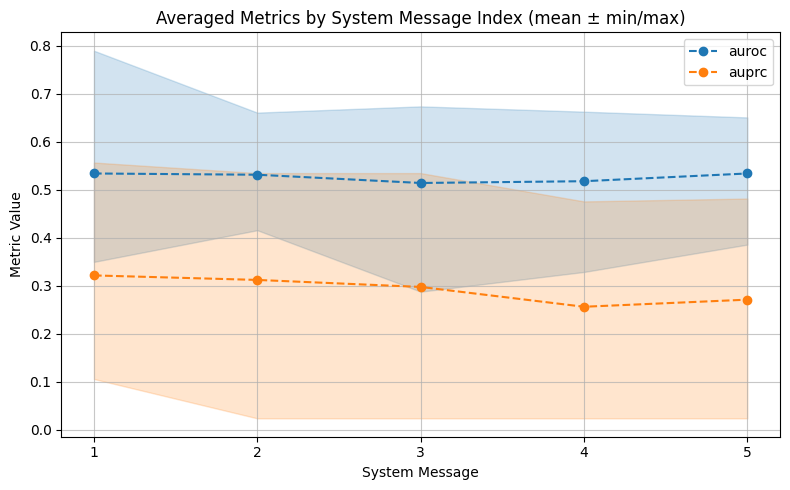

In [101]:
metrics_to_plot = ["auroc", "auprc"] #, "normalized_auprc"]
# Use more visually distinct and colorblind-friendly colors
colors = [ '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(8, 5))

for metric, color in zip(metrics_to_plot, colors):
    # group by System Message Index and aggregate
    grouped = df_metrics_by_model_task.groupby("System Message Index")[metric].agg(['mean', 'min', 'max'])
    x = grouped.index + 1
    y_mean = grouped['mean']
    y_min = grouped['min']
    y_max = grouped['max']
    plt.plot(x, y_mean, marker="o", label=metric, color=color, linestyle='--')
    plt.fill_between(x, y_min, y_max, alpha=0.2, color=color)

plt.xlabel("System Message")
plt.xticks(np.arange(1, 6))
plt.xlim(0.8, df_metrics_by_model_task["System Message Index"].max() + 1.2)
plt.ylabel("Metric Value")
plt.title("Averaged Metrics by System Message Index (mean ± min/max)")
plt.legend()
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()


Average Tokenization time, Average Inference Time, Average Input Tokens, Average Output Tokens for each model, task, and dataset

In [102]:
df_metadata.groupby(["model_name", "task", "dataset"]).agg({
    "Tokenization Time": "mean",
    "Inference Time": "mean",
    "Input Tokens": "mean",
    "Output Tokens": "mean"
}).reset_index().sort_values(by=["model_name", "task", "dataset"]).head(20)


,model_name,task,dataset,Tokenization Time,Inference Time,Input Tokens,Output Tokens
0,DeepseekR1Llama8b,aki,eicu,0.005689,19.243242,3330.779878,804.916667
1,DeepseekR1Llama8b,mortality,eicu,0.012568,46.969110,7923.580000,1422.654000
2,Gemma3,aki,eicu,0.004514,21.530292,4006.713814,300.000000
3,Gemma3,mortality,eicu,0.015104,39.295709,10312.960000,300.000000
4,Llama3,aki,eicu,0.006509,2.583773,3360.779878,80.683740
5,Llama3,mortality,eicu,0.012617,4.512945,7953.580000,112.368000
6,Llama3,sepsis,eicu,0.006639,4.435609,3393.778571,146.866735
7,Mistral,aki,eicu,0.012681,4.068876,4322.716667,124.784959
8,Mistral,mortality,eicu,0.023746,8.805725,10627.780000,205.906000
9,Mistral,sepsis,eicu,0.012852,3.994197,4352.067347,123.726735


---

### Mistral 7B

Summary:
- System Message 0 response not using correct label
- System Message 1 has best performance

In [16]:
df_mistral7b = get_predictions_by_model(df_metadata, "Mistral")
df_mistral7b.head()

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,System Message,System Message Index,model_name,task,dataset,timestamp
10820,You are an experienced doctor in Intensive Car...,0,0.00,not-diagnosis,The patient's creatinine level is within the n...,0.011632,5.051853,4062,158,You are a helpful assistant and experienced me...,0,Mistral,aki,eicu,20250608_182848
10821,You are an experienced doctor in Intensive Car...,0,0.95,not-aki,The patient's creatinine levels remained stabl...,0.012297,6.061033,4266,193,You are a helpful assistant and experienced me...,1,Mistral,aki,eicu,20250608_182848
10822,You are an experienced doctor in Intensive Car...,0,0.10,not-aki,Kidney function appears stable based on creati...,0.012798,4.051667,4373,124,You are a helpful assistant and experienced me...,2,Mistral,aki,eicu,20250608_182848
10823,You are an experienced doctor in Intensive Car...,0,0.10,not-aki,Kidney function appears stable based on creati...,0.013072,4.229980,4412,130,You are a helpful assistant and experienced me...,3,Mistral,aki,eicu,20250608_182848
10824,You are an experienced doctor in Intensive Car...,0,0.10,not-aki,Kidney function appears stable based on creati...,0.013340,4.755879,4496,148,You are a helpful assistant and experienced me...,4,Mistral,aki,eicu,20250608_182848


In [17]:
counter = 0
for idx, group in df_mistral7b.groupby("System Message Index"):
    # Check for probability < 0.5 and "not" not in diagnosis
    mask_low = group["Predicted Probability"] < 0.5
    for diag in group.loc[mask_low, "Predicted Diagnosis"]:
        if "not" not in diag:
            counter += 1
    # Check for probability > 0.5 and "not" not in diagnosis
    mask_high = group["Predicted Probability"] > 0.5
    for diag in group.loc[mask_high, "Predicted Diagnosis"]:
        if "not" in diag:
            counter += 1

    print(
        f"{counter}/{len(group)} predictions for system message {idx} are inconsistent with the probability."
    )

100/2064 predictions for system message 0 are inconsistent with the probability.
1095/2064 predictions for system message 1 are inconsistent with the probability.
1203/2064 predictions for system message 2 are inconsistent with the probability.
1315/2064 predictions for system message 3 are inconsistent with the probability.
1650/2064 predictions for system message 4 are inconsistent with the probability.


Averaged Metrics over Tasks and Datasets

In [18]:
# Group by System Message Index and calculate metrics
df_mistral7b_grouped = (
    df_mistral7b.groupby("System Message Index")
    .apply(
        lambda x: calculate_all_metrics(
            x["Target Label"].values, x["Predicted Probability"].values
        )
    )
    .reset_index()
)
# Expand the metrics dictionary into separate columns
metrics_df = df_mistral7b_grouped[0].apply(pd.Series)
df_mistral7b_grouped = pd.concat(
    [df_mistral7b_grouped.drop(columns=0), metrics_df], axis=1
)
# Display the grouped DataFrame
df_mistral7b_grouped

C:\Users\janbe\AppData\Local\Temp\ipykernel_23676\1913835533.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,System Message Index,auroc,auprc,normalized_auprc,specificity,f1_score,accuracy,balanced_accuracy,precision,recall,mcc,kappa,minpse
0,0,0.481,0.163,0.940,0.787,0.174,0.683,0.489,0.159,0.192,-0.020,-0.020,0.174
1,1,0.705,0.443,2.548,0.523,0.420,0.583,0.696,0.277,0.869,0.299,0.213,0.304
2,2,0.369,0.150,0.864,0.875,0.215,0.756,0.534,0.245,0.192,0.074,0.073,0.192
3,3,0.369,0.152,0.877,0.884,0.192,0.759,0.524,0.230,0.164,0.056,0.055,0.174
4,4,0.500,0.237,1.365,0.714,0.338,0.673,0.597,0.261,0.479,0.157,0.145,0.261


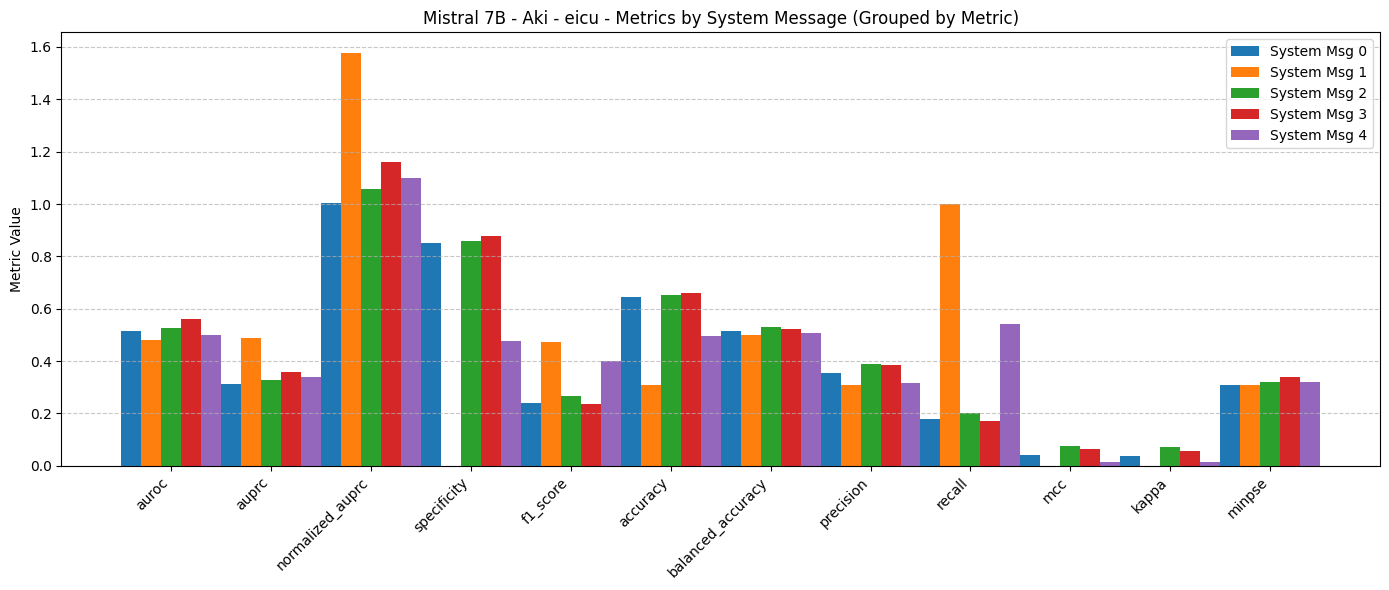

In [19]:
df_temp = get_predictions_by_model_task_dataset(df_metadata, "Mistral", "aki", "eicu")
plot_metrics(df_temp, "Mistral 7B - Aki - eicu")

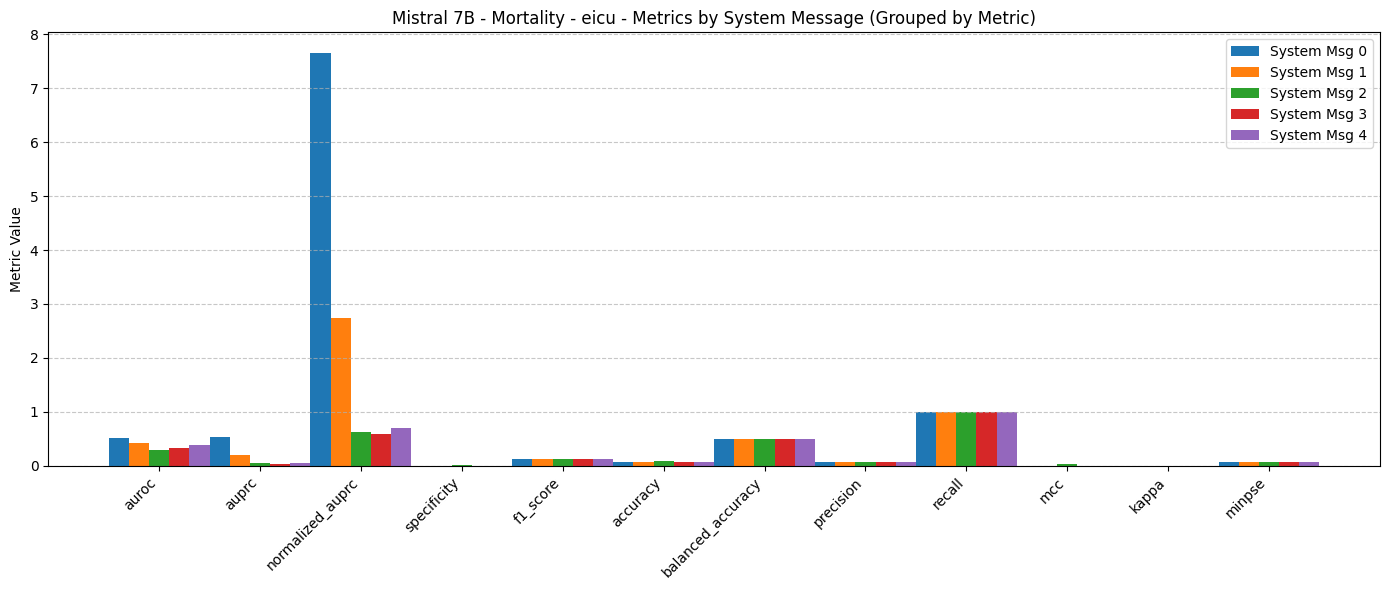

In [20]:
df_temp = get_predictions_by_model_task_dataset(
    df_metadata, "Mistral", "mortality", "eicu"
)

plot_metrics(df_temp, "Mistral 7B - Mortality - eicu")

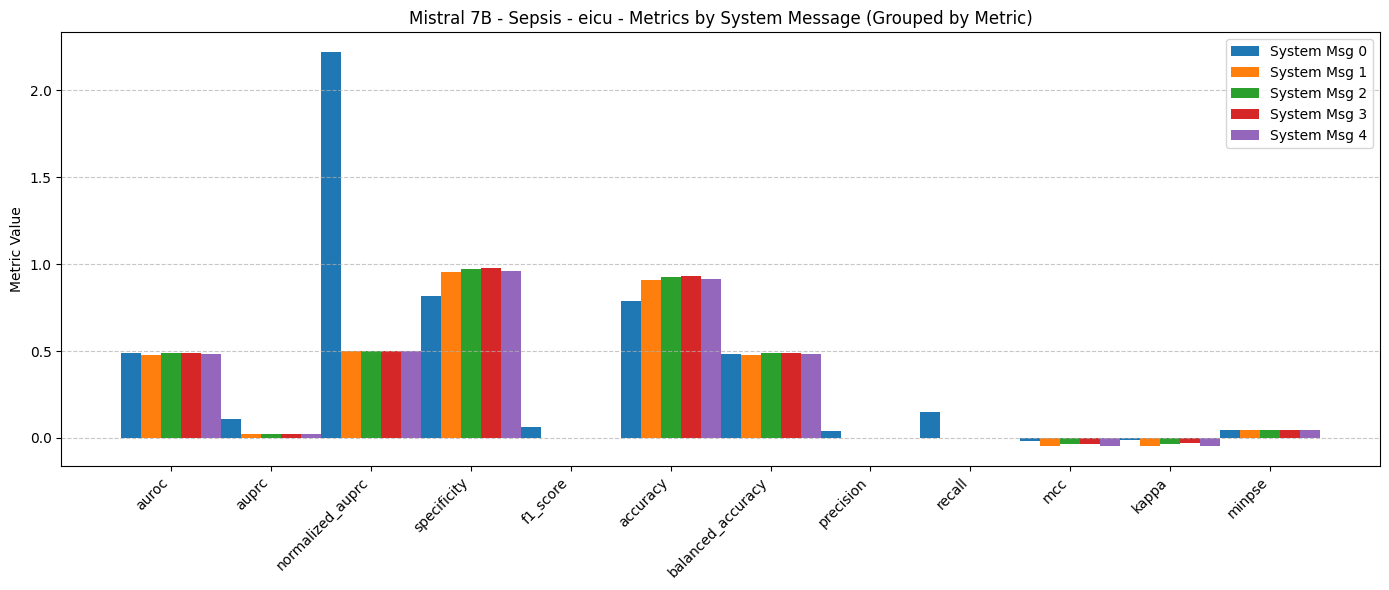

In [21]:
df_temp = get_predictions_by_model_task_dataset(
    df_metadata, "Mistral", "sepsis", "eicu"
)

plot_metrics(df_temp, "Mistral 7B - Sepsis - eicu")

### Llama-3 8B

Summary:
- System message 0 has best performance
- System Message 0 does not reply with correct label
- probability and label consistent for all samples


In [22]:
df_llama3_8b = get_predictions_by_model(df_metadata, "Llama3")
df_llama3_8b.head()

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,System Message,System Message Index,model_name,task,dataset,timestamp
500,You are an experienced doctor in Intensive Car...,0,0.00,not-diagnosis,"Based on the provided data, the patient's crea...",0.006283,2.981291,3155,95,You are a helpful assistant and experienced me...,0,Llama3,aki,eicu,20250608_181930
501,You are an experienced doctor in Intensive Car...,0,0.00,not-aki,Kidney function stable: creatinine 0.9 mg/dL (...,0.005769,1.995243,3315,61,You are a helpful assistant and experienced me...,1,Llama3,aki,eicu,20250608_181930
502,You are an experienced doctor in Intensive Car...,0,0.05,not-aki,Kidney function stable: creatinine 0.9 mg/dL (...,0.005815,2.001122,3400,61,You are a helpful assistant and experienced me...,2,Llama3,aki,eicu,20250608_181930
503,You are an experienced doctor in Intensive Car...,0,0.05,not-aki,Kidney function stable: creatinine 0.9 mg/dL (...,0.005694,2.054575,3431,63,You are a helpful assistant and experienced me...,3,Llama3,aki,eicu,20250608_181930
504,You are an experienced doctor in Intensive Car...,0,0.05,not-aki,Kidney function stable: creatinine 0.9 mg/dL (...,0.005774,2.038414,3502,61,You are a helpful assistant and experienced me...,4,Llama3,aki,eicu,20250608_181930


In [23]:
counter = 0
for idx, group in df_llama3_8b.groupby("System Message Index"):
    # Check for probability < 0.5 and "not" not in diagnosis
    mask_low = group["Predicted Probability"] < 0.5
    for diag in group.loc[mask_low, "Predicted Diagnosis"]:
        if "not" not in diag:
            counter += 1
    # Check for probability > 0.5 and "not" not in diagnosis
    mask_high = group["Predicted Probability"] > 0.5
    for diag in group.loc[mask_high, "Predicted Diagnosis"]:
        if "not" in diag:
            counter += 1

    print(
        f"{counter}/{len(group)} predictions for system message {idx} are inconsistent with the probability."
    )

0/2064 predictions for system message 0 are inconsistent with the probability.
0/2064 predictions for system message 1 are inconsistent with the probability.
0/2064 predictions for system message 2 are inconsistent with the probability.
0/2064 predictions for system message 3 are inconsistent with the probability.
0/2064 predictions for system message 4 are inconsistent with the probability.


Averaged Metrics over Tasks and Datasets

In [24]:
# Group by System Message Index and calculate metrics
df_llama3_8b_grouped = (
    df_llama3_8b.groupby("System Message Index")
    .apply(
        lambda x: calculate_all_metrics(
            x["Target Label"].values, x["Predicted Probability"].values
        )
    )
    .reset_index()
)
# Expand the metrics dictionary into separate columns
metrics_df = df_llama3_8b_grouped[0].apply(pd.Series)
df_llama3_8b_grouped = pd.concat(
    [df_llama3_8b_grouped.drop(columns=0), metrics_df], axis=1
)
# Display the grouped DataFrame
df_llama3_8b_grouped

C:\Users\janbe\AppData\Local\Temp\ipykernel_23676\2564300095.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,System Message Index,auroc,auprc,normalized_auprc,specificity,f1_score,accuracy,balanced_accuracy,precision,recall,mcc,kappa,minpse
0,0,0.510,0.396,2.275,0.319,0.247,0.367,0.458,0.156,0.596,-0.068,-0.040,0.207
1,1,0.367,0.142,0.815,0.565,0.098,0.494,0.362,0.071,0.159,-0.215,-0.186,0.174
2,2,0.308,0.149,0.859,0.608,0.102,0.529,0.380,0.076,0.153,-0.190,-0.171,0.174
3,3,0.324,0.166,0.952,0.523,0.122,0.469,0.367,0.085,0.212,-0.203,-0.168,0.174
4,4,0.369,0.179,1.029,0.365,0.170,0.366,0.369,0.110,0.373,-0.202,-0.135,0.174


Single Metrics on Task-Dataset combinations

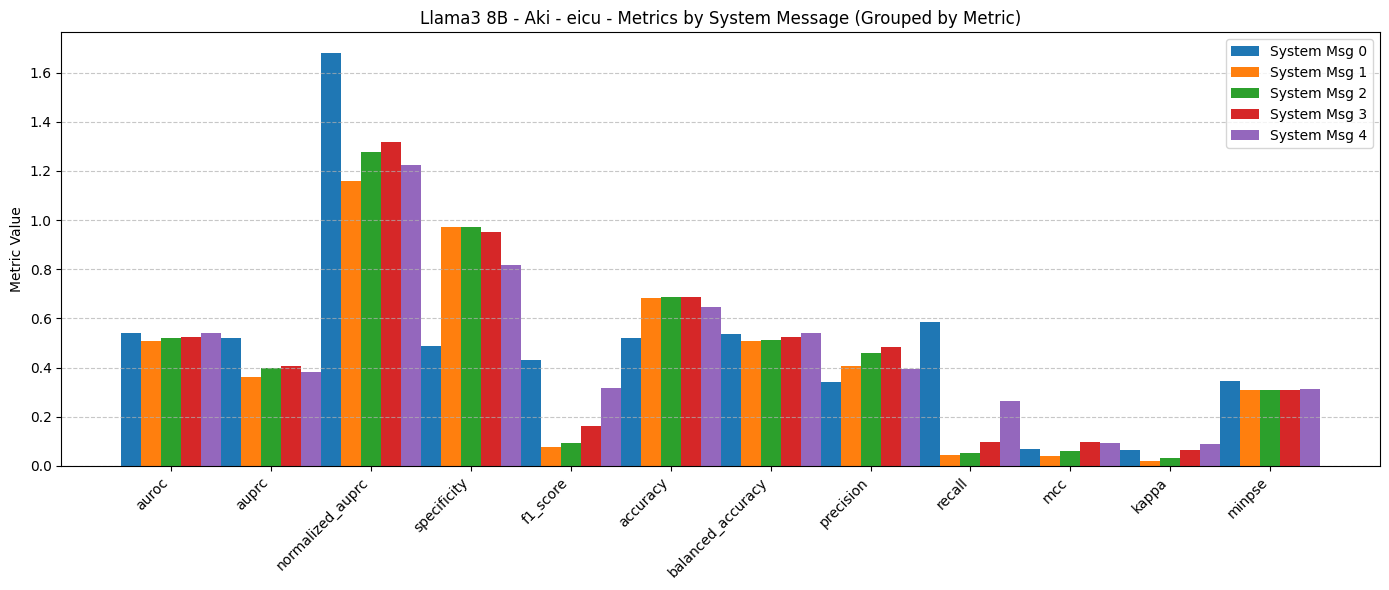

In [25]:
df_temp = get_predictions_by_model_task_dataset(df_metadata, "Llama3", "aki", "eicu")
plot_metrics(df_temp, "Llama3 8B - Aki - eicu")

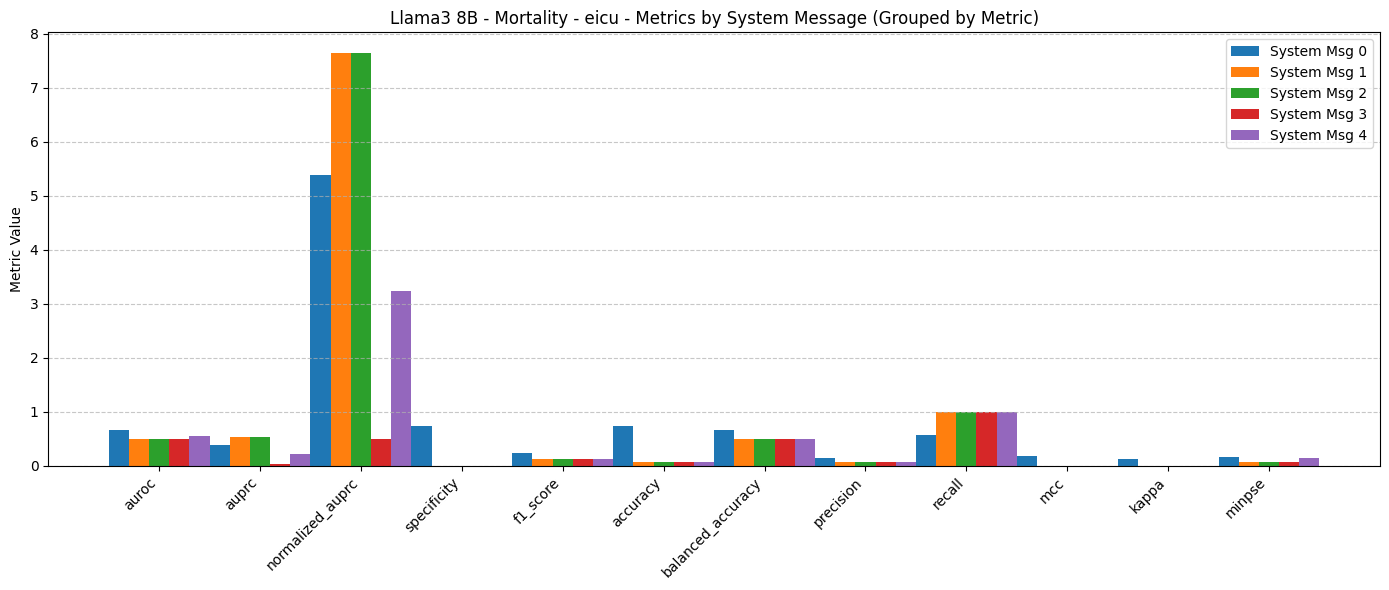

In [26]:
df_temp = get_predictions_by_model_task_dataset(df_metadata, "Llama3", "mortality", "eicu")
plot_metrics(df_temp, "Llama3 8B - Mortality - eicu")

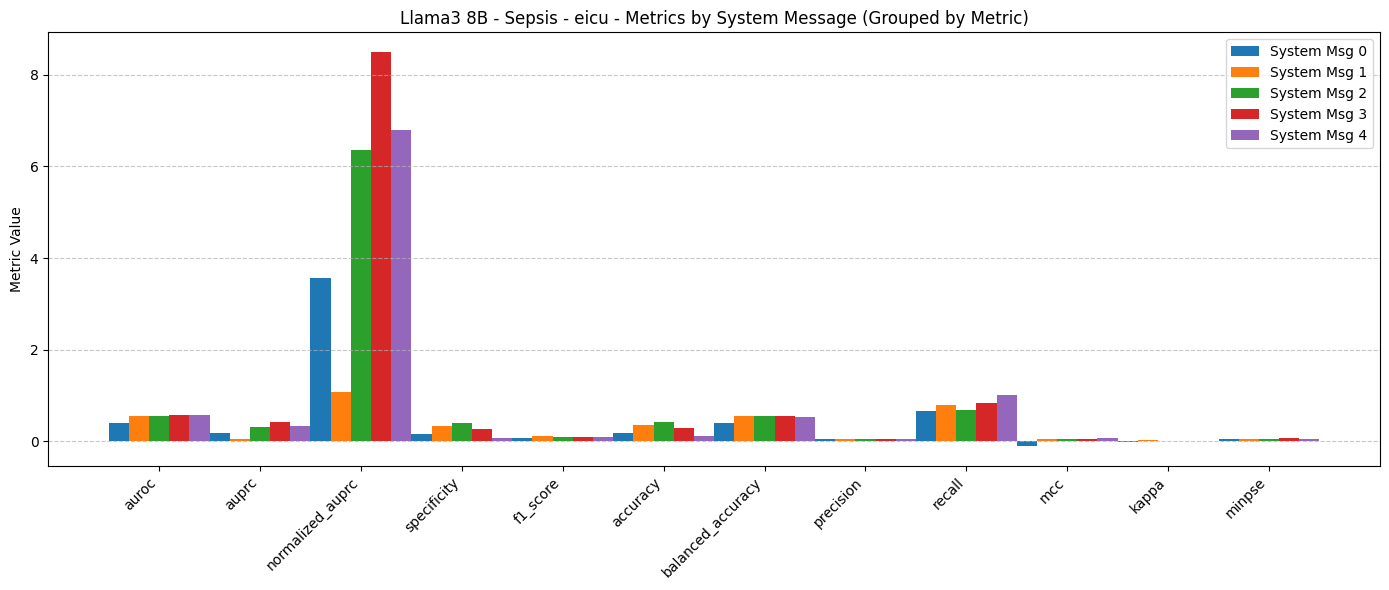

In [27]:
df_temp = get_predictions_by_model_task_dataset(df_metadata, "Llama3", "sepsis", "eicu")
plot_metrics(df_temp, "Llama3 8B - Sepsis - eicu")

### Gemma 3

Summary:
- System Message 1 was not sufficient for the model to understand how to phrase the output
- long inference time of ca. 40sec
- System Message 2 with the best performance
- many misclassified samples (probabilities and label not matching)

In [94]:
df_gemma3_12b = get_predictions_by_model(df_metadata, "Gemma3")
df_gemma3_12b.tail()

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,System Message,System Message Index,model_name,task,dataset,timestamp
29885,NaN,0,0.85,diagnosis,The patient exhibits several concerning trends...,0.0044,21.4758,3790,300,NaN,0,Gemma3,aki,eicu,20250616_135330
29886,NaN,0,0.75,aki,Acute kidney injury is suspected. Creatinine d...,0.0044,21.5801,3961,300,NaN,1,Gemma3,aki,eicu,20250616_135330
29887,NaN,0,0.78,aki,Likely acute kidney injury. Creatinine decreas...,0.0051,21.4746,4056,300,NaN,2,Gemma3,aki,eicu,20250616_135330
29888,NaN,0,0.78,aki,Acute kidney injury is likely. Creatinine decr...,0.0045,21.4068,4088,300,NaN,3,Gemma3,aki,eicu,20250616_135330
29889,NaN,0,0.78,aki,Likely acute kidney injury. Creatinine decreas...,0.0054,21.5229,4162,300,NaN,4,Gemma3,aki,eicu,20250616_135330


In [95]:
counter = 0
for idx, group in df_gemma3_12b.groupby("System Message Index"):
    # Check for probability < 0.5 and "not" not in diagnosis
    mask_low = group["Predicted Probability"] < 0.5
    for diag in group.loc[mask_low, "Predicted Diagnosis"]:
        if "not" not in diag:
            counter += 1
    # Check for probability > 0.5 and "not" not in diagnosis
    mask_high = group["Predicted Probability"] > 0.5
    for diag in group.loc[mask_high, "Predicted Diagnosis"]:
        if "not" in diag:
            counter += 1

    print(
        f"{counter}/{len(df_gemma3_12b)} predictions for system message {idx} are inconsistent with the probability."
    )

99/3830 predictions for system message 0 are inconsistent with the probability.
132/3830 predictions for system message 1 are inconsistent with the probability.
172/3830 predictions for system message 2 are inconsistent with the probability.
228/3830 predictions for system message 3 are inconsistent with the probability.
304/3830 predictions for system message 4 are inconsistent with the probability.


Averaged Metrics over Tasks and Datasets

In [96]:
# Group by System Message Index and calculate metrics
df_gemma3_12b_grouped = (
    df_gemma3_12b.groupby("System Message Index")
    .apply(
        lambda x: calculate_all_metrics(
            x["Target Label"].values, x["Predicted Probability"].values
        )
    )
    .reset_index()
)
# Expand the metrics dictionary into separate columns
metrics_df = df_gemma3_12b_grouped[0].apply(pd.Series)
gemma3_12b_grouped = pd.concat([df_gemma3_12b_grouped.drop(columns=0), metrics_df], axis=1)
# Display the grouped DataFrame
df_gemma3_12b_grouped

C:\Users\janbe\AppData\Local\Temp\ipykernel_23676\4030317164.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,System Message Index,0
0,0,"{'auroc': 0.561, 'auprc': 0.537, 'normalized_a..."
1,1,"{'auroc': 0.582, 'auprc': 0.249, 'normalized_a..."
2,2,"{'auroc': 0.53, 'auprc': 0.378, 'normalized_au..."
3,3,"{'auroc': 0.525, 'auprc': 0.369, 'normalized_a..."
4,4,"{'auroc': 0.555, 'auprc': 0.37, 'normalized_au..."


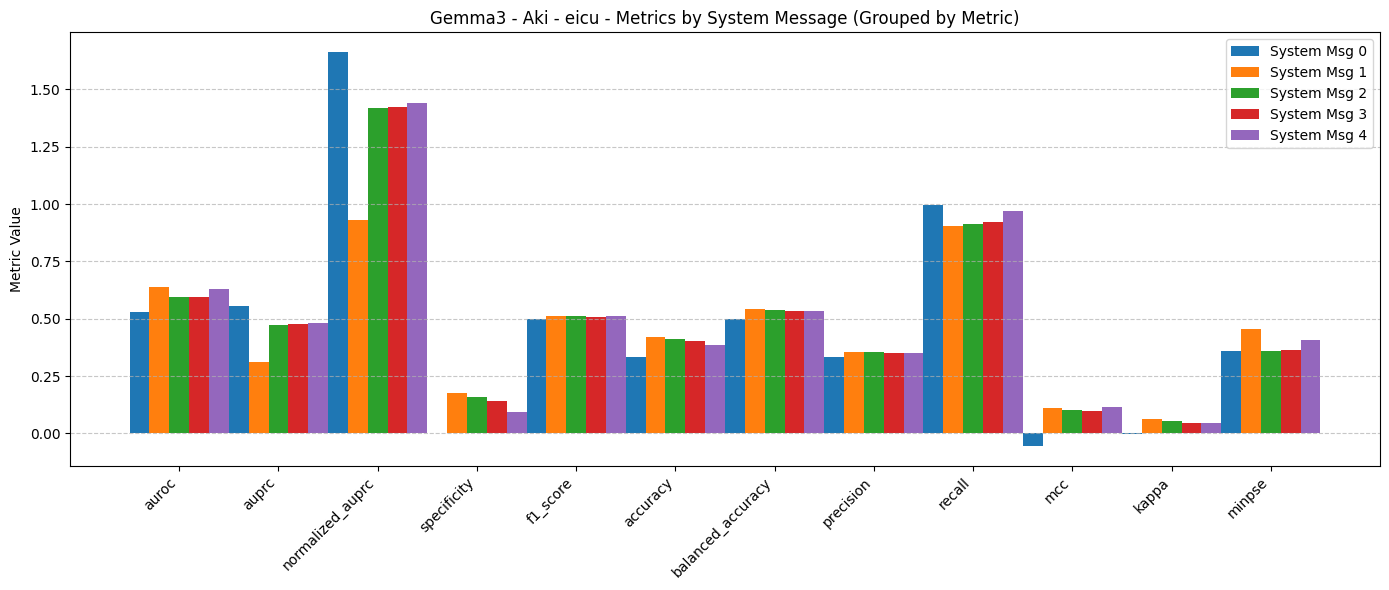

In [97]:
df_temp = get_predictions_by_model_task_dataset(df_metadata, "Gemma3", "aki", "eicu")
plot_metrics(df_temp, "Gemma3 - Aki - eicu")

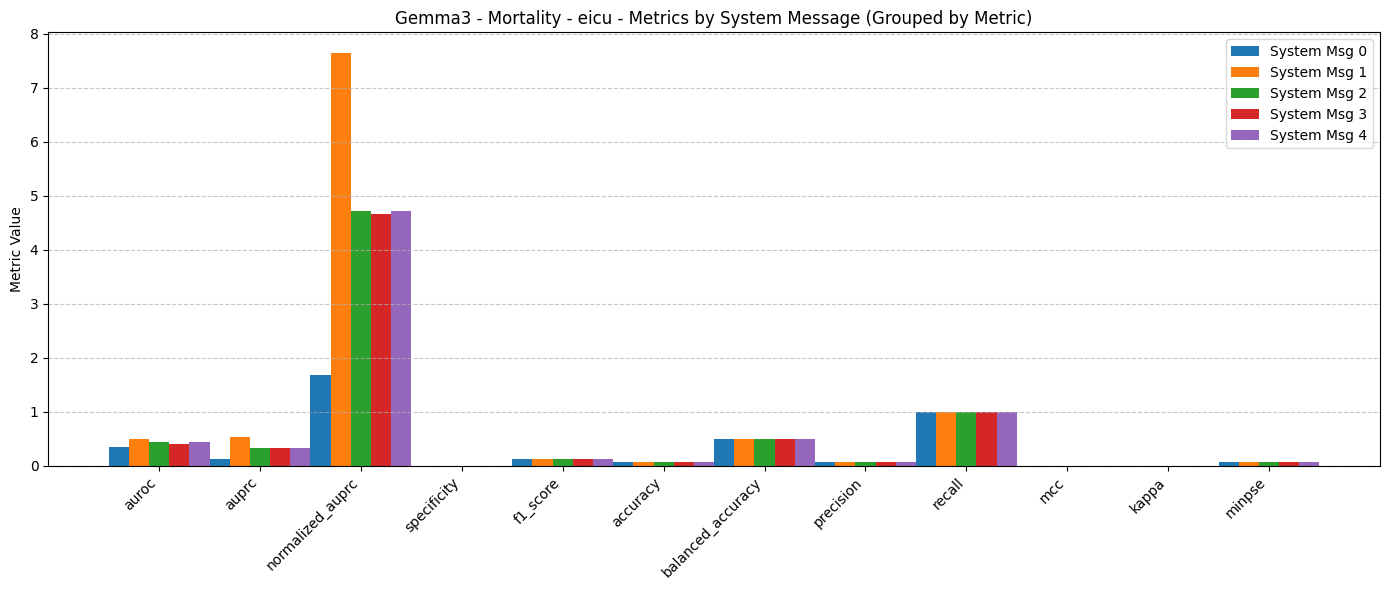

In [98]:
df_temp = get_predictions_by_model_task_dataset(
    df_metadata, "Gemma3", "mortality", "eicu"
)

plot_metrics(df_temp, "Gemma3 - Mortality - eicu")

In [33]:
# df_temp = get_predictions_by_model_task_dataset(df_metadata, "Gemma3", "sepsis", "eicu")
# plot_metrics(df_temp, "Gemma3 - Sepsis - eicu")

### DeepSeek-R1-Distill-Llama-8B

Summary:
- System message 1 with best performance
- a lot of inconsisten probability/label pairs

In [68]:
df_deepseekr1_llama8b = get_predictions_by_model(df_metadata, "DeepseekR1Llama8b")
df_deepseekr1_llama8b.head()

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,System Message,System Message Index,model_name,task,dataset,timestamp
21140,You are an experienced doctor in Intensive Car...,0,0.00,not-diagnosis,The patient's serum creatinine and blood urea ...,0.006719,18.120857,3125,762,You are a helpful assistant and experienced me...,0,DeepseekR1Llama8b,aki,eicu,20250613_112431
21141,You are an experienced doctor in Intensive Car...,0,0.10,not-aki,Kidney function appears stable: creatinine rem...,0.005799,17.041536,3285,712,You are a helpful assistant and experienced me...,1,DeepseekR1Llama8b,aki,eicu,20250613_112431
21142,You are an experienced doctor in Intensive Car...,0,0.20,not-aki,"Urine output remains above the threshold, and ...",0.005626,18.262427,3370,765,You are a helpful assistant and experienced me...,2,DeepseekR1Llama8b,aki,eicu,20250613_112431
21143,You are an experienced doctor in Intensive Car...,0,0.20,not-aki,"Creatinine and BUN within normal limits, urine...",0.005679,14.153721,3401,592,You are a helpful assistant and experienced me...,3,DeepseekR1Llama8b,aki,eicu,20250613_112431
21144,You are an experienced doctor in Intensive Car...,0,0.08,not-aki,Kidney function stable: creatinine 0.90 mg/dL ...,0.005858,14.778650,3472,616,You are a helpful assistant and experienced me...,4,DeepseekR1Llama8b,aki,eicu,20250613_112431


In [69]:
counter = 0
for idx, group in df_gemma3_12b.groupby("System Message Index"):
    # Check for probability < 0.5 and "not" not in diagnosis
    mask_low = group["Predicted Probability"] < 0.5
    for diag in group.loc[mask_low, "Predicted Diagnosis"]:
        if "not" not in diag:
            counter += 1
    # Check for probability > 0.5 and "not" not in diagnosis
    mask_high = group["Predicted Probability"] > 0.5
    for diag in group.loc[mask_high, "Predicted Diagnosis"]:
        if "not" in diag:
            counter += 1

    print(
        f"{counter}/{len(df_gemma3_12b)} predictions for system message {idx} are inconsistent with the probability."
    )

99/500 predictions for system message 0 are inconsistent with the probability.
132/500 predictions for system message 1 are inconsistent with the probability.
172/500 predictions for system message 2 are inconsistent with the probability.
228/500 predictions for system message 3 are inconsistent with the probability.
304/500 predictions for system message 4 are inconsistent with the probability.


Averaged Metrics over Tasks and Datasets

In [70]:
# Group by System Message Index and calculate metrics
df_deepseekr1_llama8b_grouped = (
    df_deepseekr1_llama8b.groupby("System Message Index")
    .apply(
        lambda x: calculate_all_metrics(
            x["Target Label"].values, x["Predicted Probability"].values
        )
    )
    .reset_index()
)
# Expand the metrics dictionary into separate columns
metrics_df = df_deepseekr1_llama8b_grouped[0].apply(pd.Series)
df_deepseekr1_llama8b_grouped = pd.concat(
    [df_deepseekr1_llama8b_grouped.drop(columns=0), metrics_df], axis=1
)
# Display the grouped DataFrame
df_deepseekr1_llama8b_grouped

C:\Users\janbe\AppData\Local\Temp\ipykernel_23676\1958634007.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,System Message Index,auroc,auprc,normalized_auprc,specificity,f1_score,accuracy,balanced_accuracy,precision,recall,mcc,kappa,minpse
0,0,0.536,0.316,1.099,0.734,0.332,0.618,0.532,0.334,0.330,0.065,0.065,0.330
1,1,0.561,0.355,1.233,0.795,0.330,0.652,0.547,0.371,0.298,0.100,0.099,0.335
2,2,0.550,0.319,1.108,0.773,0.344,0.644,0.549,0.366,0.324,0.101,0.100,0.344
3,3,0.550,0.338,1.175,0.780,0.346,0.649,0.552,0.373,0.324,0.108,0.108,0.338
4,4,0.570,0.333,1.157,0.797,0.349,0.659,0.557,0.387,0.317,0.121,0.120,0.366


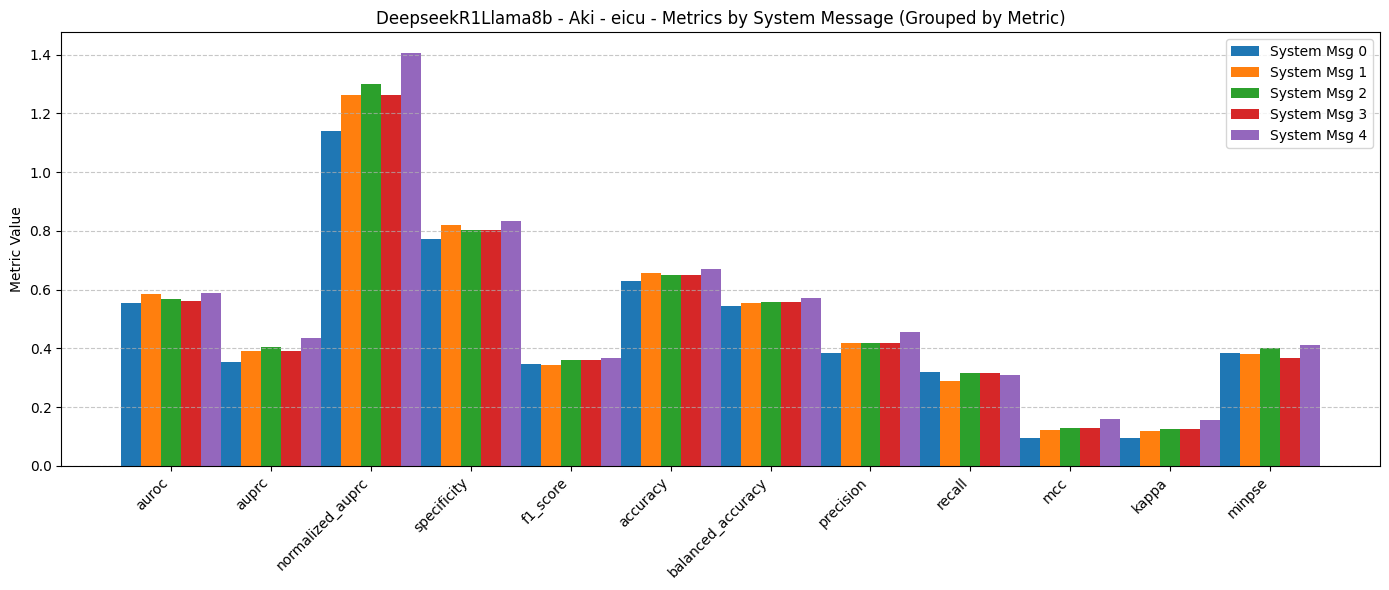

In [71]:
df_temp1 = get_predictions_by_model_task_dataset(
    df_metadata, "DeepseekR1Llama8b", "aki", "eicu"
)
plot_metrics(df_temp1, "DeepseekR1Llama8b - Aki - eicu")

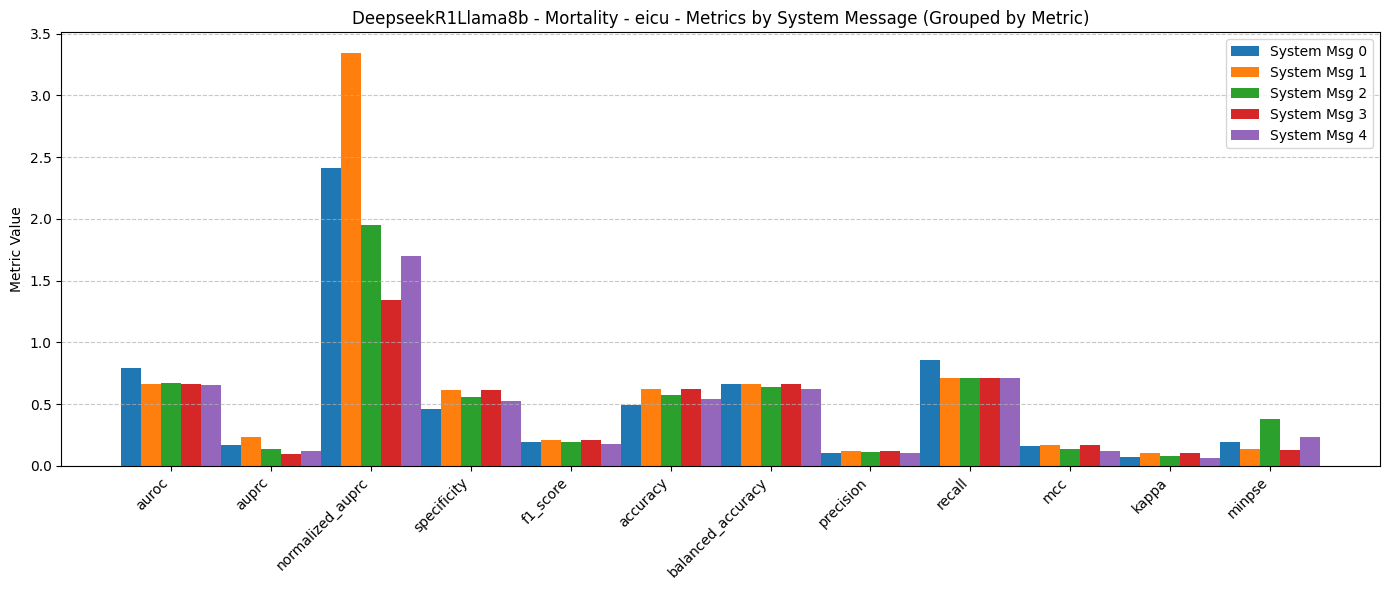

In [72]:
df_temp2 = get_predictions_by_model_task_dataset(
    df_metadata, "DeepseekR1Llama8b", "mortality", "eicu"
)

plot_metrics(df_temp2, "DeepseekR1Llama8b - Mortality - eicu")

In [39]:
# df_temp = get_predictions_by_model_task_dataset(df_metadata, "Gemma3", "sepsis", "eicu")
# plot_metrics(df_temp, "Gemma3 - Sepsis - eicu")

---
## Distribution of predicted probabilities when using System Message N for all models and tasks

In [40]:
n = 1

In [41]:
df_sysmsg1 = df_metadata[df_metadata["System Message Index"] == n]
df_sysmsg1_sepsis = df_sysmsg1[df_sysmsg1["task"] == "sepsis"]

Model: Gemma3


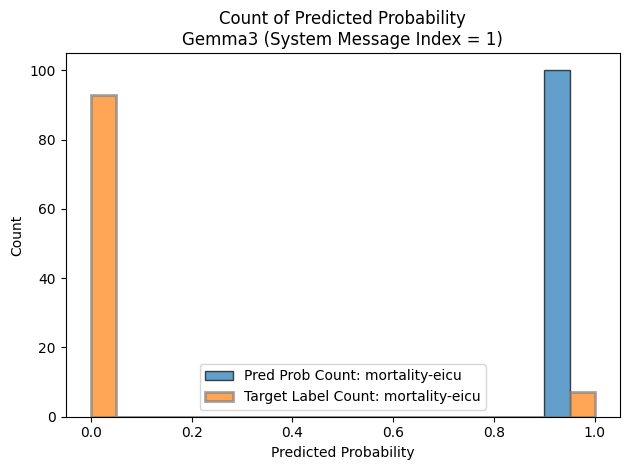

Model: Llama3


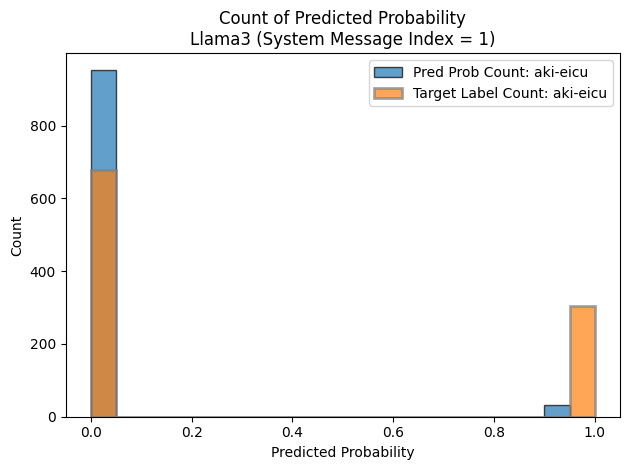

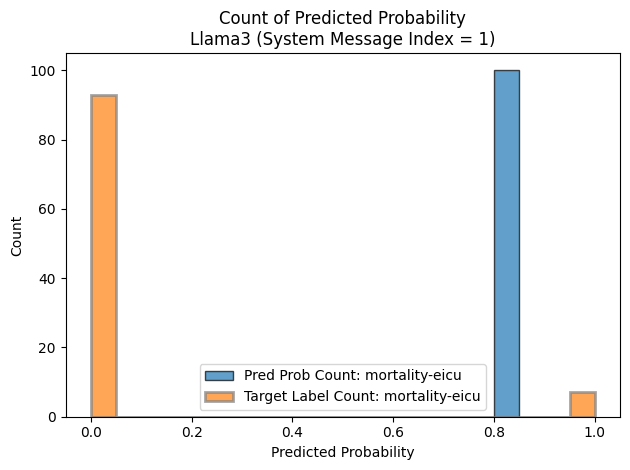

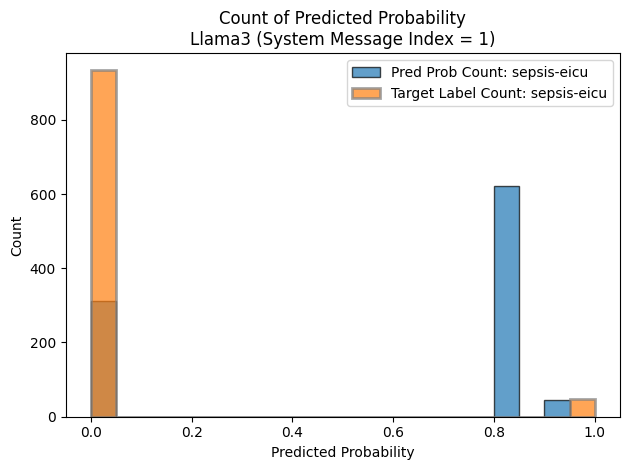

Model: Mistral


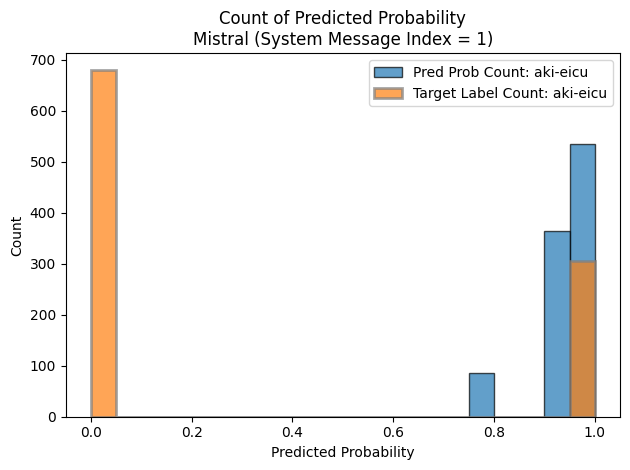

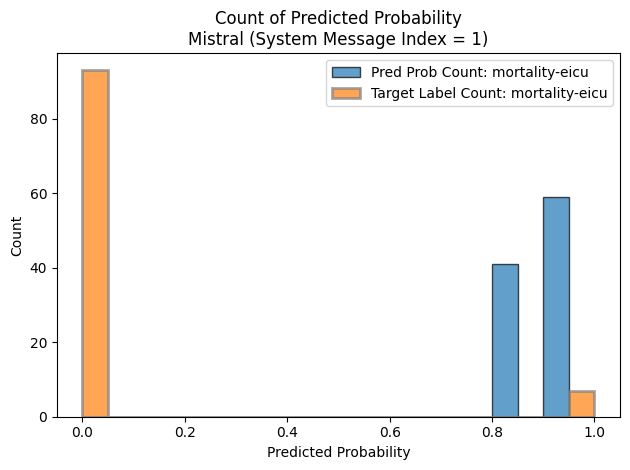

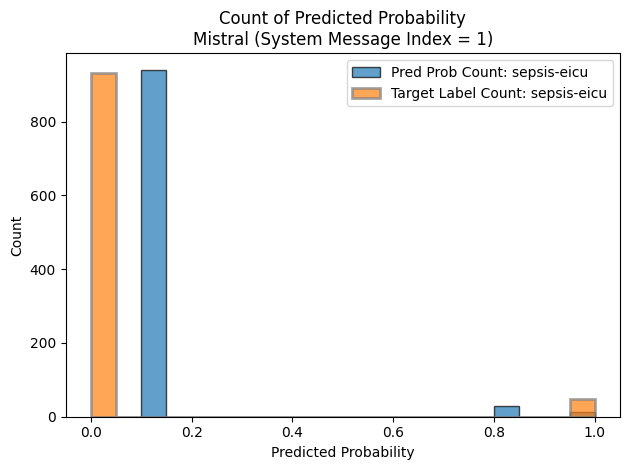

Model: DeepseekR1Llama8b


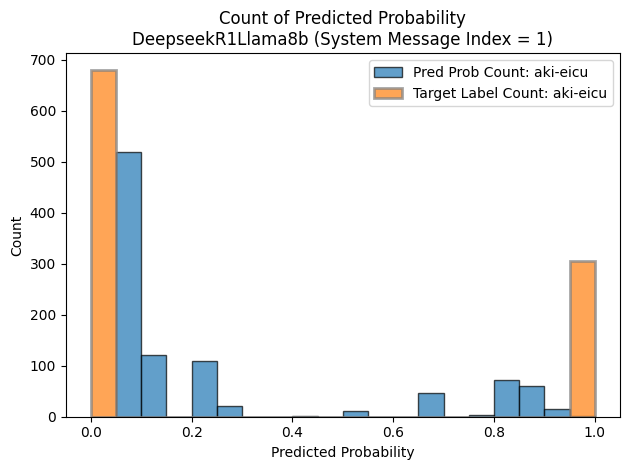

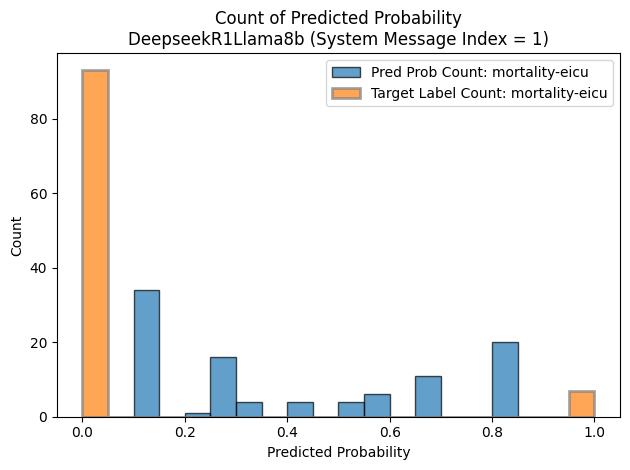

In [42]:
models = df_sysmsg1["model_name"].unique()
for model in models:
    df_model = df_sysmsg1[df_sysmsg1["model_name"] == model]
    task_dataset_combos = df_model.groupby(["task", "dataset"])
    print("Model:", model)
    # plt.figure(figsize=(10, 6))
    for (i, ((task, dataset), group)) in enumerate(task_dataset_combos):
        # Bar plot for Predicted Probability (rounded to nearest 0.05 for binning)
        bins = np.arange(0, 1.05, 0.05)
        plt.hist(
            group['Predicted Probability'],
            bins=bins,
            alpha=0.7,
            label=f'Pred Prob Count: {task}-{dataset}',
            edgecolor='black'
        )
        # Overlay bars for Target Label (same bins)
        # Plot Target Label as a separate histogram (side-by-side, not overlayed)
        plt.hist(
            group['Target Label'],
            bins=bins,
            alpha=0.7,
            label=f'Target Label Count: {task}-{dataset}',
            edgecolor='gray',
            histtype='stepfilled',
            linewidth=2
        )
        plt.xlabel('Predicted Probability')
        plt.ylabel('Count')
        plt.title(f'Count of Predicted Probability\n{model} (System Message Index = 1)')
        plt.legend()
        plt.tight_layout()
        plt.show()


---
## System Messages in DataFrame

In [43]:
# You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

# Your response must strictly follow this format:
# Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

# 1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
# 2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
# 3. 'explanation' should be a string providing a brief explanation of your diagnosis.

# Do not include any other text or explanations outside of the JSON object.
# Think about the probability of your prediction carefully before answering.


In [44]:
# You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

# Your response must strictly follow this format:
# Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

# 1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
# 2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
# 3. 'explanation' should be a string providing a brief explanation of your diagnosis.

# Here is a positive example:
# {
#   "diagnosis": "aki",
#   "probability": "89",
#   "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
# }

# Here is a negative example:
# {
#   "diagnosis": "not-aki",
#   "probability": "8",
#   "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
# }

# Do not include any other text or explanations outside of the JSON object.
# Think about the probability of your prediction carefully before answering.


In [45]:
# You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

# Your response must strictly follow this format:
# Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

# 1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
# 2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
# 3. 'explanation' should be a string providing a brief explanation of your diagnosis.

# Here is a positive example:
# {
#   "diagnosis": "aki",
#   "probability": "89",
#   "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
# }

# Here is a negative example:
# {
#   "diagnosis": "not-aki",
#   "probability": "8",
#   "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
# }

# CRITICAL: Probability calibration guidelines:
# - 0-20: Very unlikely, clear absence of condition with normal parameters
# - 20-40: Unlikely, some concerning signs but insufficient evidence
# - 40-60: Uncertain, mixed evidence or borderline findings
# - 60-80: Likely, multiple indicators support diagnosis
# - 80-100: Very likely, strong evidence with clear clinical criteria met

# Do not include any other text or explanations outside of the JSON object.
# Think about the probability of your prediction carefully before answering.


In [46]:
# You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

# Your response must strictly follow this format:
# Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

# 1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
# 2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
# 3. 'explanation' should be a string providing a brief explanation of your diagnosis.

# Here is a positive example:
# {
#   "diagnosis": "aki",
#   "probability": "89",
#   "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
# }

# Here is a negative example:
# {
#   "diagnosis": "not-aki",
#   "probability": "8",
#   "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
# }

# CRITICAL: Probability calibration guidelines:
# - 0-20: Very unlikely, clear absence of condition with normal parameters
# - 20-40: Unlikely, some concerning signs but insufficient evidence
# - 40-60: Uncertain, mixed evidence or borderline findings
# - 60-80: Likely, multiple indicators support diagnosis
# - 80-100: Very likely, strong evidence with clear clinical criteria met

# Note: ICU patients often present with abnormal baseline values due to their critical condition. Consider the clinical context and severity of deviations when assessing for the target condition.

# Do not include any other text or explanations outside of the JSON object.
# Think about the probability of your prediction carefully before answering.


In [47]:
# You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

# Your response must strictly follow this format:
# Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

# 1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
# 2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
# 3. 'explanation' should be a string providing a brief explanation of your diagnosis.

# Here is a positive example:
# {
#   "diagnosis": "aki",
#   "probability": "89",
#   "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
# }

# Here is a negative example:
# {
#   "diagnosis": "not-aki",
#   "probability": "8",
#   "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
# }

# CRITICAL: Probability calibration guidelines:
# - 0-20: Very unlikely, clear absence of condition with normal parameters
# - 20-40: Unlikely, some concerning signs but insufficient evidence
# - 40-60: Uncertain, mixed evidence or borderline findings
# - 60-80: Likely, multiple indicators support diagnosis
# - 80-100: Very likely, strong evidence with clear clinical criteria met

# --- JSON Schema ---
# {
#   "diagnosis": "string"  // Must be either "aki" or "not-aki"
#   "probability": "integer" // Value between 0 (no diagnosis) and 100 (definite diagnosis)
#   "explanation": "string" // Concise clinical reasoning for the diagnosis and probability
# }

# Note: ICU patients often present with abnormal baseline values due to their critical condition. Consider the clinical context and severity of deviations when assessing for the target condition.

# Do not include any other text or explanations outside of the JSON object.
# Think about the probability of your prediction carefully before answering.
